<a href="https://colab.research.google.com/github/prakash-bisht/NN_Architecture_From_Scratch/blob/main/GPT_to_llama2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

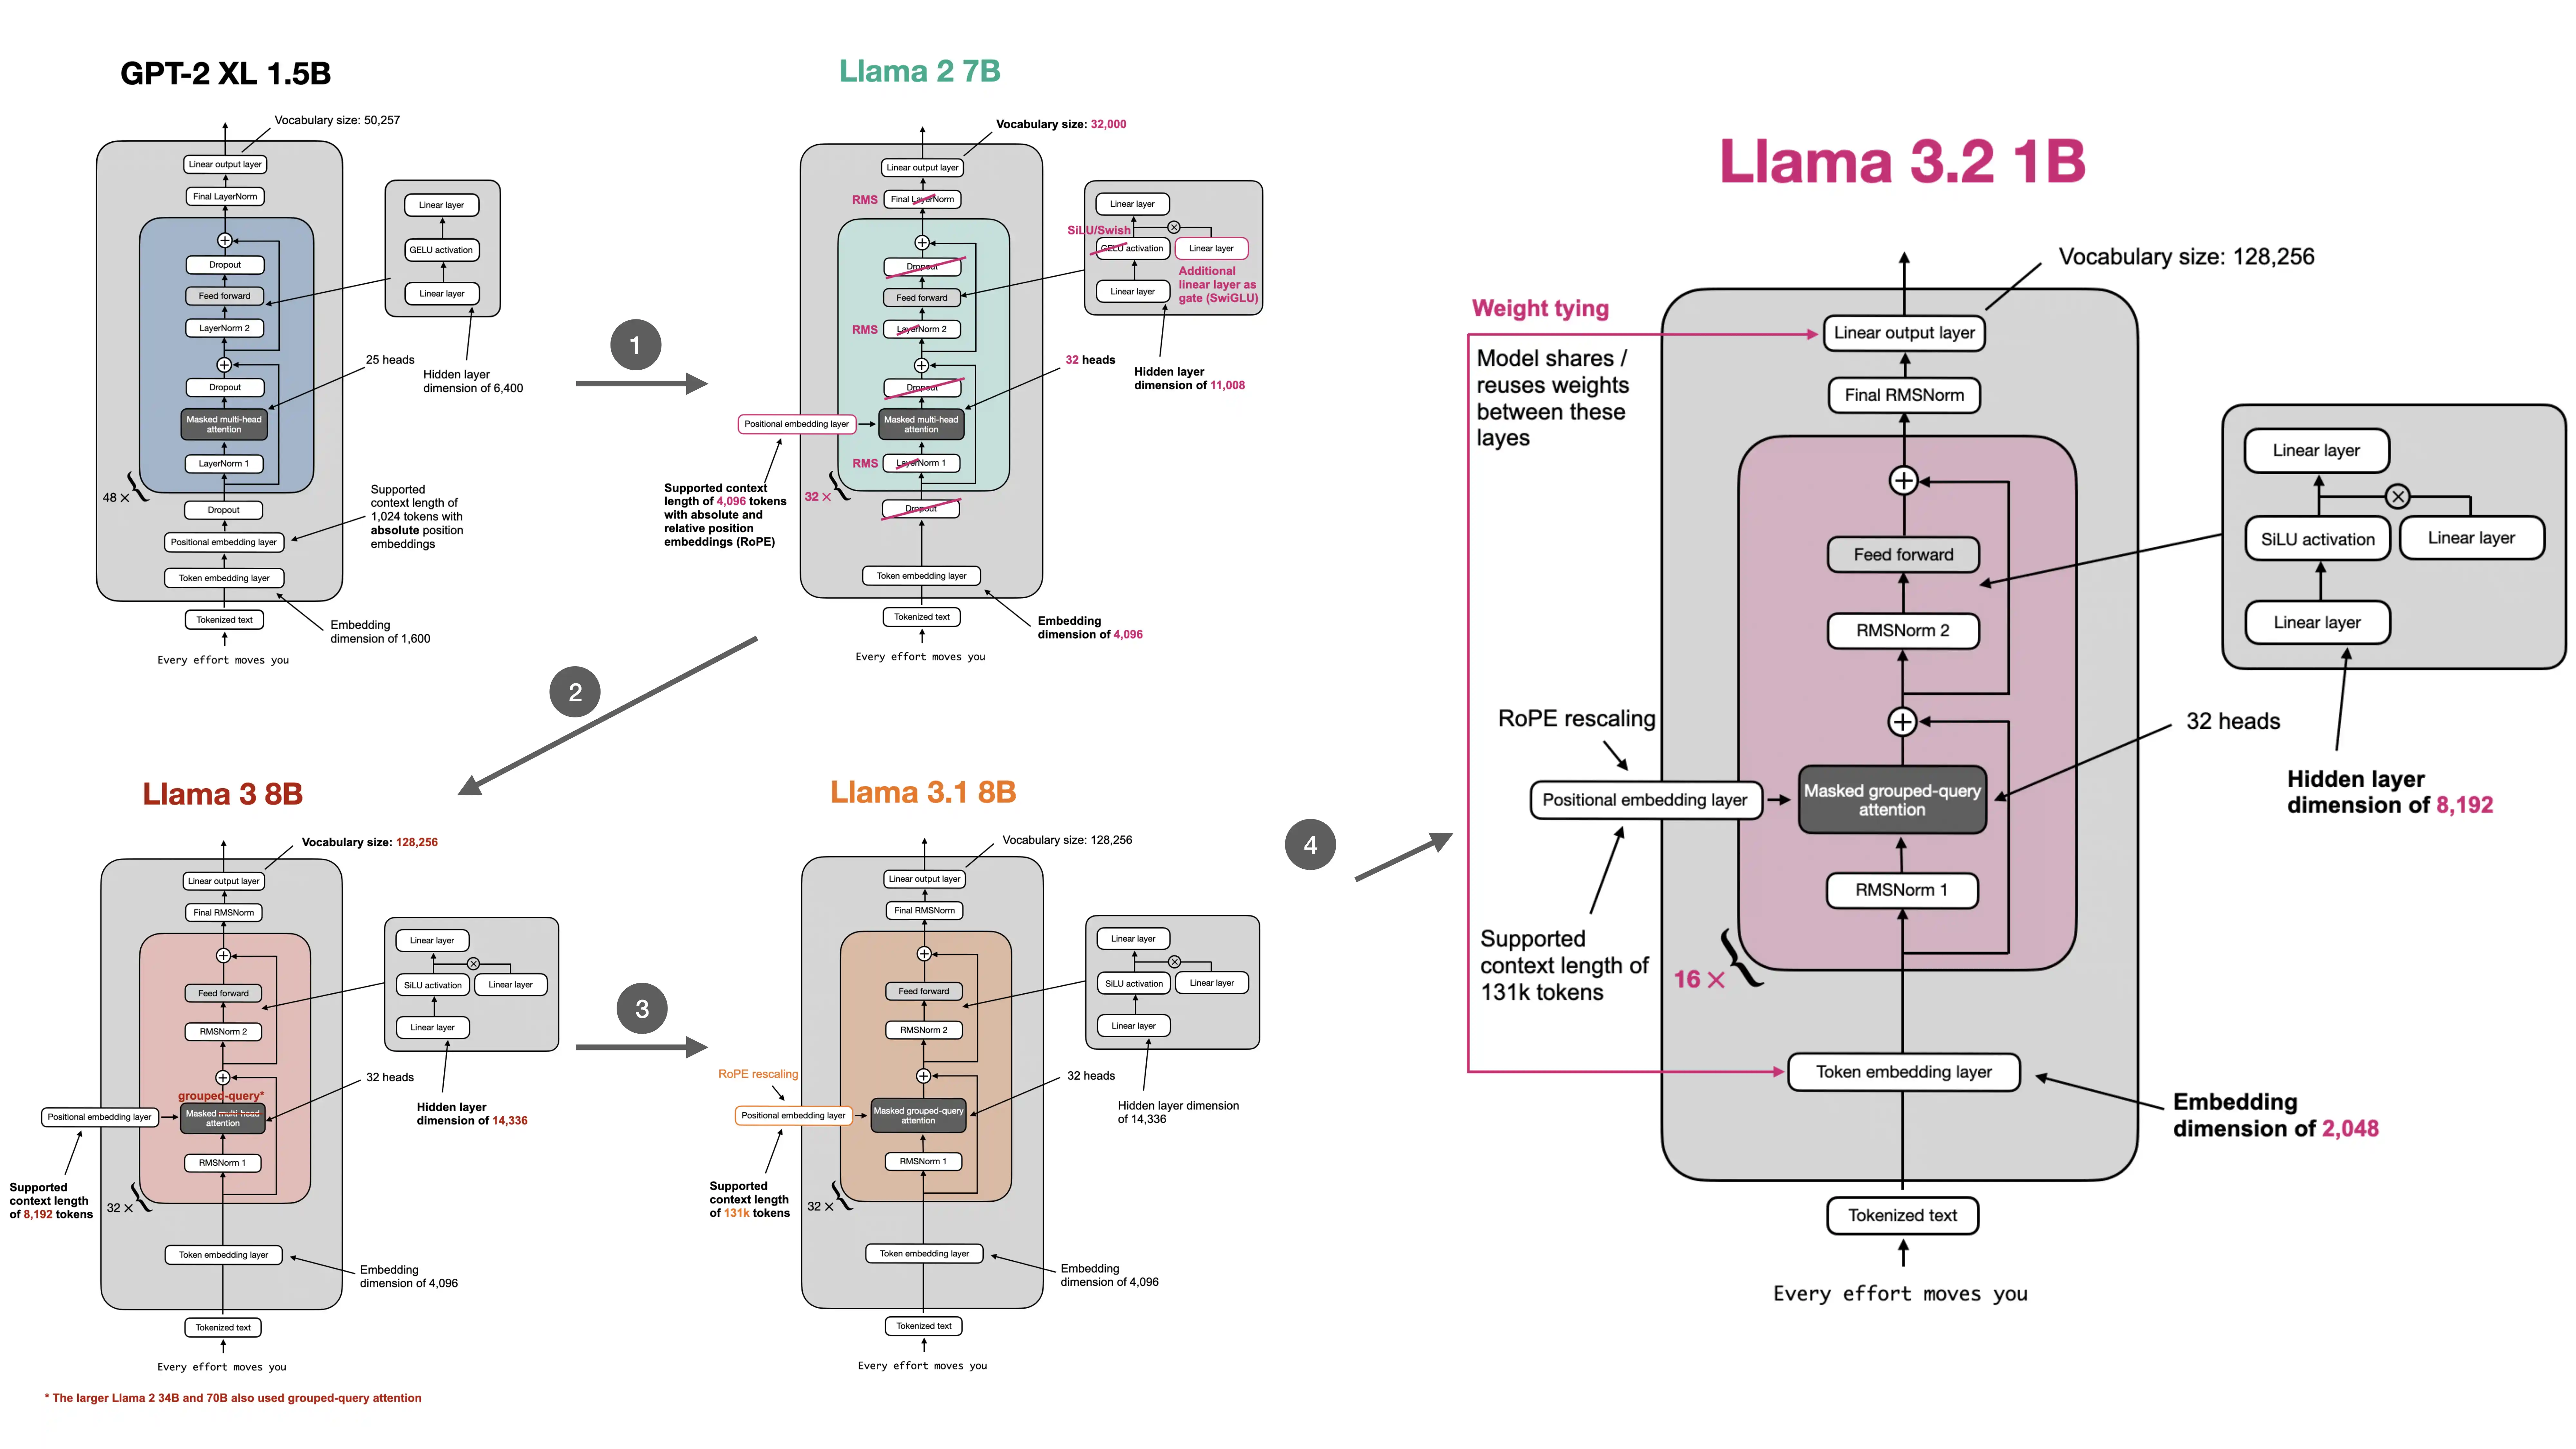

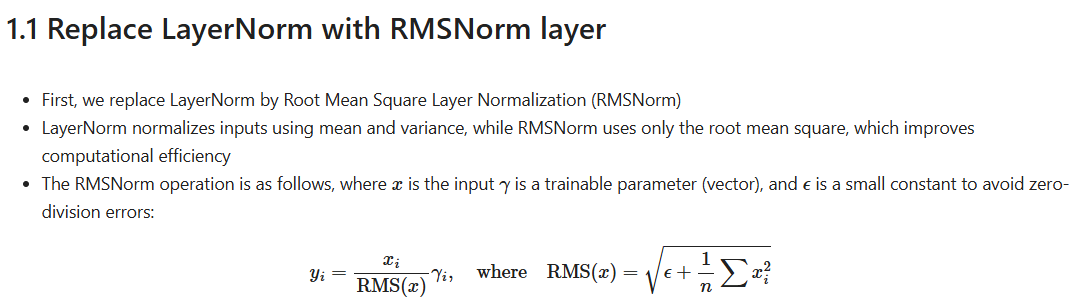

In [23]:
import torch
import torch.nn as nn

class LayerNorm(nn.Module):  # for GPT
  def __init__(self,emb_dim):
    super().__init__()
    self.eps = 1e-5
    self.scale = nn.Parameter(torch.ones(emb_dim))
    self.shift = nn.Parameter(torch.zeros(emb_dim))

  def forward(self,x):
    mean = x.mean(dim=-1,keepdim=True)
    var = x.var(dim=-1,keepdim=True)
    norm_x = (x - mean) / torch.sqrt(var + self.eps)
    return norm_x * self.scale + self.shift


class RMSNorm(nn.Module):  # For llama2
  def __init__(self,emb_dim,eps=1e-5):
    super().__init__()
    self.eps = eps
    self.emb_dim = emb_dim
    self.weight = nn.Parameter(torch.ones(self.emb_dim)).float()

  def forward(self,x):
    means = x.pow(2).mean(dim=-1,keepdim=True)
    x_normed = x * torch.rsqrt(self.eps + means)
    return (x_normed * self.weight).to(dtype=x.dtype)


1.2 Replace GELU with SiLU activation
Llama uses the SiLU activation function (instead of GELU), which is also known as the Swish function.


In [24]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

class SiLU(nn.Module):
  def __init__(self):
    super(SiLU,self).__init__()

  def forward(self,x):
    return x * torch.sigmoid(x)

 1.3 Update the FeedForward module

In [43]:
class FeedForward(nn.Module):   #gpt
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)


class FeedForward(nn.Module):     #llama2
  def __init__(self,cfg):
    super().__init__()
    self.fc1 = nn.Linear(cfg['emb_dim'],cfg["hidden_dim"],dtype=cfg["dtype"],bias=False)
    self.fc2 = nn.Linear(cfg['emb_dim'],cfg["hidden_dim"],dtype=cfg["dtype"],bias=False)
    self.fc3 = nn.Linear(cfg["hidden_dim"], cfg["emb_dim"], dtype=cfg["dtype"], bias=False) # Corrected dimension
    self.silu = SiLU() # Instantiate the SiLU activation function


  def forward(self,x):
    x_fc1 = self.fc1(x)
    x_fc2 = self.fc2(x)
    x = self.silu(x_fc1) * x_fc2

    return self.fc3(x)

1.4 Implement RoPE

In [26]:
# self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])  #gpt position embedding

In [44]:
def precompute_rope_params(head_dim, theta_base=10_000, context_length=4096):

  assert head_dim % 2 == 0

  inv_freq = 1.0 / (theta_base ** (torch.arange(0,head_dim,2)[:(head_dim // 2)].float() / head_dim))
  positions = torch.arange(context_length)
  angles = positions[:,None] * inv_freq[None,:] # Shape: (context_length, head_dim // 2)
  angles = torch.cat([angles,angles],dim = 1) # Shape: (context_length, head_dim)
  cos = torch.cos(angles)
  sin = torch.sin(angles)

  return cos,sin

def compute_rope(x, cos, sin):
  batch_size,num_heads,seq_len,head_dim = x.shape

  assert head_dim % 2 == 0

  x1 = x[...,:head_dim//2]
  x2 = x[...,head_dim//2:]

  cos = cos[:seq_len,:].unsqueeze(0).unsqueeze(0)# Shape: (1, 1, seq_len, head_dim)
  sin = sin[:seq_len,:].unsqueeze(0).unsqueeze(0)

  rotated = torch.cat((-x2,x1),dim=-1)
  x_rotated = (x * cos) + (rotated * sin)

  return x_rotated.to(dtype=x.dtype)

1.5 Add RoPE to MultiHeadAttention module

In [45]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, num_heads, dtype=None):  # ,dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert d_out % num_heads == 0

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads

        self.W_query = nn.Linear(d_in,d_out,bias = False,dtype=dtype)
        self.W_key = nn.Linear(d_in,d_out,bias = False,dtype=dtype)
        self.W_value = nn.Linear(d_in,d_out,bias = False,dtype=dtype)
        self.register_buffer('mask',torch.triu(torch.ones(context_length,context_length),diagonal=1))

        cos,sin = precompute_rope_params(self.head_dim,context_length)
        self.register_buffer('cos',cos)
        self.register_buffer('sin',sin)

    def forward(self,x):
        b,num_tokens,d_in = x.shape
        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)

        keys = keys.transpose(1,2) # Shape: (b, num_heads, num_tokens, head_dim)
        queries = queries.transpose(1,2)
        values = values.transpose(1,2)

        keys = compute_rope(keys,self.cos,self.sin)
        queries = compute_rope(queries,self.cos,self.sin)

        attn_scores = queries @ keys.transpose(2,3) #shape (b, num_heads, num_tokens, num_tokens)
        mask_bool = self.mask.bool()[:num_tokens,:num_tokens]
        attn_scores.masked_fill_(mask_bool,-torch.inf)
        attn_weights = torch.softmax(attn_scores/ keys.shape[-1] ** 0.5,dim=-1)

        context_vec = (attn_weights @ values).transpose(1,2) #shape (b, num_tokens, num_heads, head_dim)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.reshape(b,num_tokens,self.d_out)

        return context_vec

1.6
Update the TransformerBlock module

1 replace LayerNorm with RMSNorm

2 remove dropout

3 remove the qkv_bias setting

4 add the dtype setting

In [46]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dtype=cfg["dtype"]
            # dropout=cfg["drop_rate"],
            # qkv_bias=cfg["qkv_bias"]
        )
        self.ff = FeedForward(cfg)

        # self.norm1 = LayerNorm(cfg["emb_dim"])
        # self.norm2 = LayerNorm(cfg["emb_dim"])
        self.norm1 = RMSNorm(cfg["emb_dim"])
        self.norm2 = RMSNorm(cfg["emb_dim"])

        # self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)   # Shape [batch_size, num_tokens, emb_size]
        # x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed-forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        # x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        return x

1.7 Update the model class

remove absolute positional embeddings since we have RoPE embeddings now,
replace LayerNorm with RMSNorm,
remove dropout
add the dtype setting

In [47]:
# class GPTModel(nn.Module):
class Llama2Model(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"], dtype=cfg["dtype"])
        # self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        # self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        # self.final_norm = LayerNorm(cfg["emb_dim"])
        self.final_norm = RMSNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False, dtype=cfg["dtype"])

    def forward(self, in_idx):
        # batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        # pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds  # + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        # x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

2. Initialize model


In [48]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "emb_dim": 768,          # Embedding dimension
    "n_heads": 12,           # Number of attention heads
    "n_layers": 12,          # Number of layers
    "drop_rate": 0.1,        # Dropout rate
    "qkv_bias": False        # Query-Key-Value bias
}

In [49]:
GPT_CONFIG_1558M = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "emb_dim": 1600,         # Embedding dimension
    "n_heads": 25,           # Number of attention heads
    "n_layers": 48,          # Number of layers
    "drop_rate": 0.1,        # Dropout rate
    "qkv_bias": False        # Query-Key-Value bias
}

In [50]:
LLAMA2_CONFIG_7B = {
    "vocab_size": 32000,     # Vocabulary size
    "context_length": 4096,  # Context length
    "emb_dim": 4096,         # Embedding dimension
    "n_heads": 32,           # Number of attention heads
    "n_layers": 32,          # Number of layers
    "hidden_dim": 11008,     # NEW: Size of the intermediate dimension in FeedForward
    "dtype": torch.bfloat16  # NEW: Lower-precision dtype to reduce memory usage
}

In [51]:
model = Llama2Model(LLAMA2_CONFIG_7B)

In [52]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 6,201,544,704


In [53]:
def model_memory_size(model, input_dtype=torch.float32):
    total_params = 0
    total_grads = 0
    for param in model.parameters():
        # Calculate total number of elements per parameter
        param_size = param.numel()
        total_params += param_size
        # Check if gradients are stored for this parameter
        if param.requires_grad:
            total_grads += param_size

    # Calculate buffer size (non-parameters that require memory)
    total_buffers = sum(buf.numel() for buf in model.buffers())

    # Size in bytes = (Number of elements) * (Size of each element in bytes)
    # We assume parameters and gradients are stored in the same type as input dtype
    element_size = torch.tensor(0, dtype=input_dtype).element_size()
    total_memory_bytes = (total_params + total_grads + total_buffers) * element_size

    # Convert bytes to gigabytes
    total_memory_gb = total_memory_bytes / (1024**3)

    return total_memory_gb

print(f"float32 (PyTorch default): {model_memory_size(model, input_dtype=torch.float32):.2f} GB")
print(f"bfloat16: {model_memory_size(model, input_dtype=torch.bfloat16):.2f} GB")

float32 (PyTorch default): 48.33 GB
bfloat16: 24.17 GB


3. Load tokenizer


In [ ]:
!pip install huggingface_hub sentencepiece

In [55]:
from huggingface_hub import login
import json

with open("config.json", "r") as config_file:
    config = json.load(config_file)
    access_token = config["HF_ACCESS_TOKEN"]

login(token=access_token)

In [56]:
from huggingface_hub import hf_hub_download

tokenizer_file = hf_hub_download(
    repo_id="meta-llama/Llama-2-7b",
    filename="tokenizer.model",
    local_dir="Llama-2-7b"
)

In [57]:
import sentencepiece as spm


class LlamaTokenizer:
    def __init__(self, tokenizer_file):
        sp = spm.SentencePieceProcessor()
        sp.load(tokenizer_file)
        self.tokenizer = sp

    def encode(self, text):
        return self.tokenizer.encode(text, out_type=int)

    def decode(self, ids):
        return self.tokenizer.decode(ids)


tokenizer = LlamaTokenizer(tokenizer_file)

In [58]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text)
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)  # add batch dimension
    return encoded_tensor


def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)  # remove batch dimension
    return tokenizer.decode(flat.tolist())


def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float('-inf')).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

In [59]:
token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves", tokenizer),
    max_new_tokens=30,
    context_size=LLAMA2_CONFIG_7B["context_length"],
    top_k=1,
    temperature=0.
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves местаform mergedras Legislès während Replacejoint용용용용용용용용용용용asc Sic dynast child fé child fé child fé child
